In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary
from torchvision import models
from tqdm import tqdm

from mlfocus import util
from mlfocus.loader import MIPData, get_loaders
from mlfocus.model import ResnetModel
from mlfocus.train import train_step, validate

# try:
#     wandb
# except NameError:
#     import wandb
        
#     os.environ['WANDB_NOTEBOOK_NAME'] = 'mip_train.ipynb'
#     wandb.init(project="mip-mlfocus")
%load_ext autoreload
%autoreload 2
    

wandb: Currently logged in as: tlambert03. Use `wandb login --relogin` to force relogin


loading mips: 100%|██████████| 918/918 [00:03<00:00, 269.59it/s]


918
data shape torch.Size([1, 128, 128]) torch.float32
label shape torch.Size([1])
dataset length 918


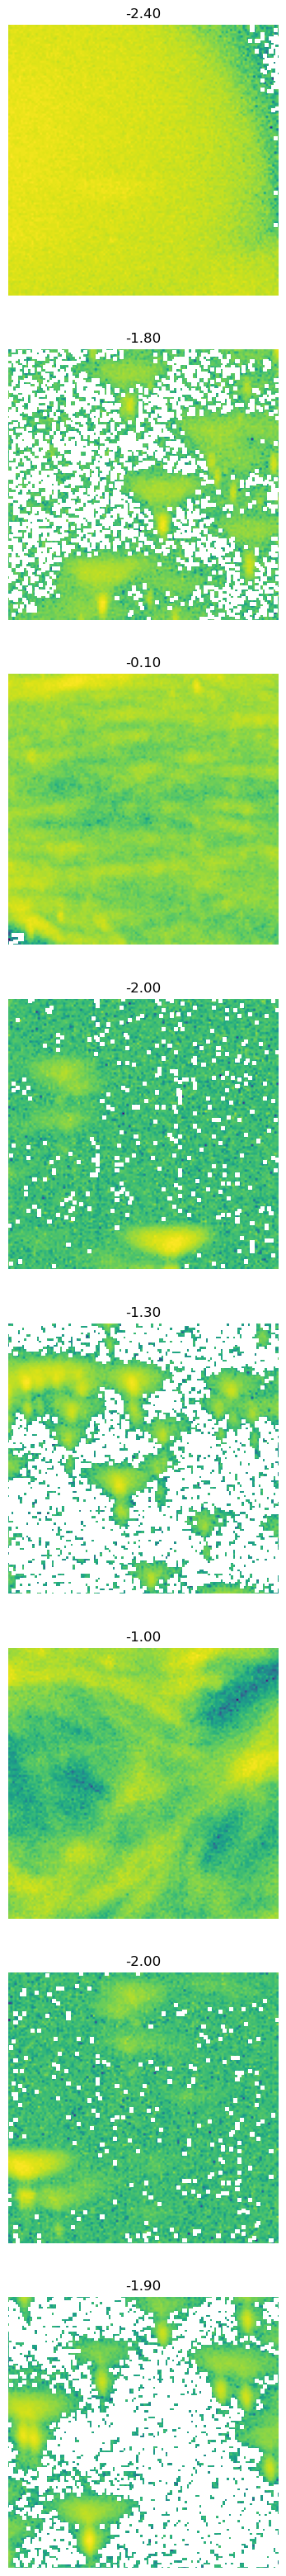

In [4]:
full_dset =  MIPData("../mlfocus_data/")
print(len(full_dset))
util.preview_data(full_dset, n=8, figsize=(10, 40))


In [57]:
from torch.utils.data import RandomSampler

model = ResnetModel(in_channels=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
batch_size = 1024
patches_per_image = 20
learning_rate = 1.5e-3
epochs = 200

train_dataset = MIPData("../mlfocus_data/", exclude=["beads"])
sampler = RandomSampler(
    train_dataset, replacement=True, num_samples=len(train_dataset) * patches_per_image
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
)
# mt_data = MIPData("../mlfocus_data/", include=["mt003"])
# mt_loader = DataLoader(mt_data, batch_size=64)
bead_data = MIPData("../mlfocus_data/", include=["beads"])
bead_loader = DataLoader(bead_data, batch_size=64)

all_loader = DataLoader(full_dset, batch_size=64)


optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

wandb.config = {
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "patches_per_image": patches_per_image,
}
wandb.watch(model)

global_len = len(train_loader.dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for e in range(epochs):
    train_step(
        train_loader,
        model=model,
        optimizer=optimizer,
        loss=criterion,
        epoch_idx=e,
        device=device,
    )

    tot_val = validate(model, all_loader, criterion)
    # mt_val = validate(model, mt_loader, criterion)
    bead_val = validate(model, bead_loader, criterion)
    wandb.log(
        {"tot_val_loss": tot_val, "bead_val": bead_val, "epoch": e}
        # {"tot_val_loss": tot_val, "mt_val": mt_val, "bead_val": bead_val, "epoch": e}
    )


loading mips: 0it [00:00, ?it/s]


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# from mlfocus.loader import MIPData

# train_loader, val_loader = load_data(
#     ROOT, test_split=0.2, batch_size=16, loader_class=MIPData
# )
# model = ResnetModel(in_channels=1)
# model.to(DEVICE)
# optimizer = Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()
# epochs = 40

# for e in range(epochs):
#     train_step(model, train_loader, optimizer, criterion, e)
#     step = e * len(train_loader.dataset)
#     validate(model, val_loader, criterion, step=step)


In [ ]:
# -> Regression
# L1  MAE
# L2  MSE

# -> Classification
# cross entropy
# binary cross entropy


In [49]:
import torch
# torch.save(model, 'models/mip_model2.pt')
model = torch.load('models/xmip_model2.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'models/xmip_model2.pt'

<AxesSubplot:xlabel='gt', ylabel='pred'>

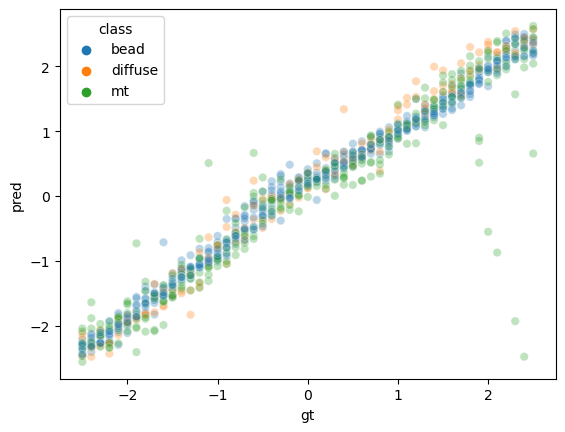

In [52]:
import seaborn as sns
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
df = util.characterize(model, full_dset, device=device, criterion=criterion)
sns.scatterplot(data=df, x="gt", y="pred", hue="class", alpha=0.3)

<AxesSubplot:xlabel='gt', ylabel='pred'>

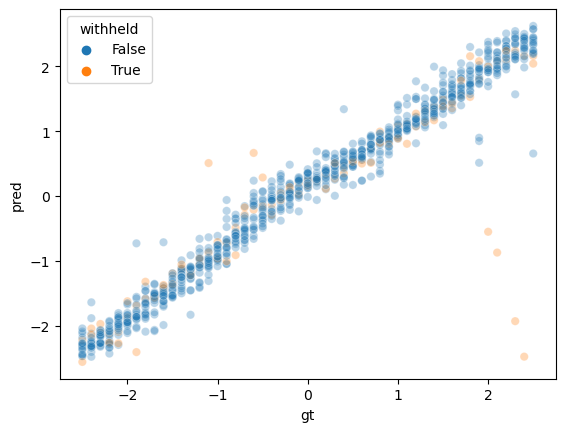

In [54]:
df['withheld'] = df['file'].str.contains("beads3", na=False) | df['file'].str.contains("mt003", na=False)
sns.scatterplot(data=df, x="gt", y="pred", hue="withheld", alpha=0.3)